# Example of using pandasql library for data analysis

In [1]:
%matplotlib inline
import pandas as pd
import pandasql as ps
from datetime import datetime
import seaborn

In [2]:
project_submissions = pd.read_csv('./data/project_submissions.csv')
daily_engagements = pd.read_csv('./data/daily_engagement.csv')
enrollments = pd.read_csv('./data/enrollments.csv')

## Simple SQL query 
getting accounts and date with maximum total time spent on Udacity

In [3]:
# pandasql code
simple_query = '''
    SELECT 
        acct, 
        total_minutes_visited,
        utc_date
    FROM daily_engagements 
    ORDER BY total_minutes_visited desc
    LIMIT 10
    '''
ps.sqldf(simple_query, locals())

,acct,total_minutes_visited,utc_date
0,317,1030.883197,2015-07-11
1,328,945.538914,2015-07-09
2,198,876.512846,2014-12-30
3,163,872.633923,2015-07-10
4,573,866.405226,2015-07-11
5,303,856.634726,2015-05-14
6,619,853.253236,2015-07-10
7,163,850.519340,2015-07-09
8,108,820.879483,2015-02-20
9,278,816.895443,2015-07-09


In [4]:
# pandas code
daily_engagements[['acct', 'total_minutes_visited', 'utc_date']].sort('total_minutes_visited', ascending = False)[:10]

,acct,total_minutes_visited,utc_date
54536,317,1030.883197,2015-07-11
56403,328,945.538914,2015-07-09
33728,198,876.512846,2014-12-30
27699,163,872.633923,2015-07-10
97492,573,866.405226,2015-07-11
51779,303,856.634726,2015-05-14
105968,619,853.253236,2015-07-10
27698,163,850.519340,2015-07-09
18394,108,820.879483,2015-02-20
47372,278,816.895443,2015-07-09


## SQL query with aggregating functions
Let's see whether there's weekly seasonality: on average students spent more time on weekends then on weekdays

In [5]:
daily_engagements['weekday'] = map(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%A'), daily_engagements.utc_date)

In [6]:
daily_engagements.head()

,acct,utc_date,num_courses_visited,total_minutes_visited,lessons_completed,projects_completed,weekday
0,0,2015-01-09,1,11.679374,0,0,Friday
1,0,2015-01-10,2,37.284887,0,0,Saturday
2,0,2015-01-11,2,53.633746,0,0,Sunday
3,0,2015-01-12,1,33.489270,0,0,Monday
4,0,2015-01-13,1,64.779678,0,0,Tuesday


In [20]:
# pandasql code
aggr_query = '''
    SELECT 
        avg(total_minutes_visited) as total_minutes_visited,
        weekday
    FROM daily_engagements 
    GROUP BY weekday
    '''
weekday_engagement = ps.sqldf(aggr_query, locals()).set_index('weekday')
weekday_engagement

,total_minutes_visited
weekday,
Friday,23.156233
Monday,26.418982
Saturday,21.725677
Sunday,23.539406
Thursday,24.685176
Tuesday,26.857676
Wednesday,25.362789


In [19]:
# pandas code

pd.DataFrame(daily_engagements.groupby('weekday').total_minutes_visited.mean())

,total_minutes_visited
weekday,
Friday,23.156233
Monday,26.418982
Saturday,21.725677
Sunday,23.539406
Thursday,24.685176
Tuesday,26.857676
Wednesday,25.362789


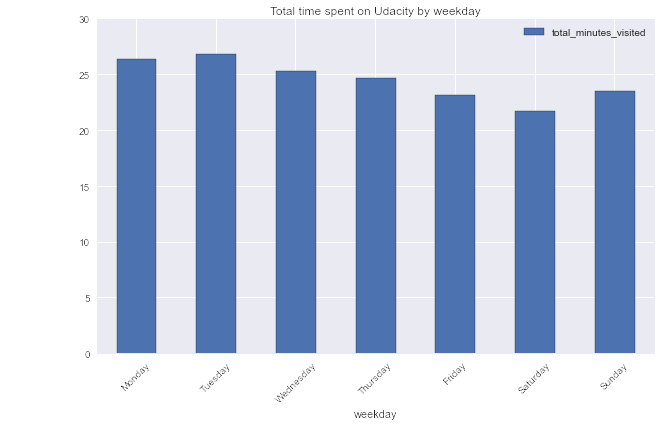

In [99]:
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_engagement.loc[week_order].plot(kind = 'bar', rot = 45, title = 'Total time spent on Udacity by weekday',
                                       figsize=(10, 6))

# Joining tables
Let's see whether students that canceled program was spending less time on Udacity within first week of enrollment.
Note we need to filter out Udacity test users not to spoil statistics. Also we need to take into account the fact that student may join several times.

In [120]:
# pandasql code
join_query = '''
    SELECT 
        avg(avg_acct_total_minutes) as total_minutes_visited, 
        status
    FROM
        (SELECT 
            avg(total_minutes_visited) as avg_acct_total_minutes, 
            status, 
            account_key
        FROM
            (SELECT 
                e.account_key, 
                e.status,
                de.total_minutes_visited,
                (cast(strftime('%s',de.utc_date) as interger) - cast(strftime('%s',e.join_date) as interger))/(24*60*60) as days_since_joining,
                (cast(strftime('%s',de.utc_date) as interger) - cast(strftime('%s',e.cancel_date) as interger))/(24*60*60) as days_before_cancel
            FROM enrollments as e JOIN daily_engagements as de ON (e.account_key = de.acct)
            WHERE (is_udacity = 0) AND (days_since_joining < 7) AND (days_since_joining >= 0)
                AND ((days_before_cancel <= 0) OR (status = 'current'))
            )
        GROUP BY status, account_key)
    GROUP BY status
''' 

ps.sqldf(join_query, locals()).set_index('status')

,total_minutes_visited
status,
canceled,30.884667
current,47.307307


In [112]:
# pandas code
join_df = pd.merge(daily_engagements, 
                   enrollments[enrollments.is_udacity == 0], 
                   how = 'inner', 
                   right_on ='account_key', 
                   left_on = 'acct')
join_df = join_df[['account_key', 'status', 'total_minutes_visited', 'utc_date', 'join_date', 'cancel_date']]

join_df['days_since_joining'] = map(lambda x: x.days, 
                                    pd.to_datetime(join_df.utc_date) - pd.to_datetime(join_df.join_date))

join_df['before_cancel'] = (pd.to_datetime(join_df.utc_date) <= pd.to_datetime(join_df.cancel_date))
join_df = join_df[join_df.before_cancel | (join_df.status == 'current')]

join_df = join_df[(join_df.days_since_joining < 7) & (join_df.days_since_joining >= 0)]
avg_account_total_minutes = pd.DataFrame(join_df.groupby(['account_key', 'status'], as_index = False)
                                                 .total_minutes_visited.mean())
pd.DataFrame(avg_account_total_minutes.groupby('status').total_minutes_visited.mean())

,total_minutes_visited
status,
canceled,30.884667
current,47.307307
